In [1]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo

%matplotlib inline

In [2]:
IMG_DIR = 'Images/'

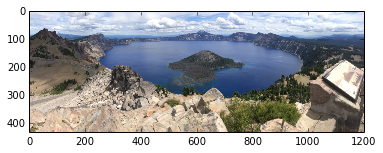

In [3]:
img = ndimage.imread(IMG_DIR+'createrLake.tiff')
plt.imshow(img)
plt.show()

In [4]:
def RGB2YCbCr(RGB):
    # Full range RGB/YCbCr conversion
    A = np.array([[[ 0.299,  0.587,  0.114],
                   [-0.169, -0.331,  0.500],
                   [ 0.500, -0.419, -0.081]]])
    
    YCbCr = np.dot(A, RGB.reshape((-1, 3)).T).T.reshape(RGB.shape) + np.array([0, 128, 128]).reshape((1,1,3))
    return YCbCr[:,:,0], YCbCr[:,:,1], YCbCr[:,:,2]

def YCbCr2RGB(y, cb, cr):
    # Full range RGB/YCbCr conversion
    B = np.array([[1.000,  0.000,  1.400],
                  [1.000, -0.343, -0.711],
                  [1.000,  1.765,  0.000]])
    
    YCbCr = np.dstack((y, cb-128, cr-128))
    return np.dot(B, YCbCr.reshape((-1, 3)).T).T.reshape(YCbCr.shape)

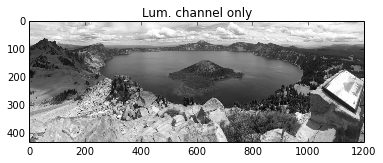

10.034 255.0


In [5]:
# Proof of concept of color space conversion
imgL, imgCb, imgCr = RGB2YCbCr(img)
plt.imshow(imgL, cmap='gray')
plt.title("Lum. channel only")
plt.show()

print np.min(imgL), np.max(imgL)

In [6]:
def genZigZag(n):
    # Used to calculate the "zigzag" traversal used to flatten JPEG blocks
    # Ascending
    swap = 0
    for idxSum in range(n):
        x = 0 if swap else idxSum
        y = idxSum if swap else 0
        if swap:
            while y >= 0:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= 0:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
    
    #Decending
    floor = 1
    for idxSum in range(n, 2*n-1):
        x = floor if swap else n-1
        y = n-1 if swap else floor
        if swap:
            while y >= floor:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= floor:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
        floor += 1

def DCT_2D(x):
    return fftpack.dct(fftpack.dct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def IDCT_2D(x):
    return fftpack.idct(fftpack.idct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def rescale(img):
    if np.min(img) < 0:
        img = img - np.min(img)
    if np.max(img) > 255:
        img = np.divide(img, np.max(img)) * 255
    return img

In [7]:
class JPEG(object):
    # Standard-specified Luminosity Table
    QL = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                   [12, 12, 14, 19,  26,  58,  60,  55],
                   [14, 13, 16, 24,  40,  57,  69,  56],
                   [14, 17, 22, 29,  51,  87,  80,  62],
                   [18, 22, 37, 56,  68, 109, 103,  77],
                   [24, 35, 55, 64,  81, 104, 113,  92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])
    
    # Standard-specified Chrominance Table
    QC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])
    
    
    def __init__(self, img, qtable, QF=50, dims=None, rescale=False):
        assert 1 <= QF < 100, "Quality Factor (QF) must be 1 <= QF < 100"
        if QF > 50:
            alpha = 2 - QF/50
        else:
            alpha = 50/QF
        
        self.raw = img
        self.qtable = qtable*alpha
        self.dims = img.shape if dims is None else dims
        self.zstride = list(genZigZag(8))
        self.linstride = list(range(64))
        self.rescale = rescale
        
        # Forward path - attributes used in compression
                                    # Original image shape: NxM
        self.transformed = None     # shape: NxM
        self.quantized = None       # shape: NxM
        self.flattened = None       # shape: (N*M/64)x64
        self.compressed = None      # shape: ???
        
        # Reverse path - attributes used in decompression
                                    # Original data shape: ???
        self.decompressed = None    # shape: (N*M/64)x64
        self.expanded = None        # shape: NxM
        self.rectified = None       # shape: NxM
        self.reconstructed = None   # shape: NxM
        
    def _process_debug(self):
        self.DCTBlocks()
        self.quantizeBlocks()
        self.flattenBlocks()
        self.compress()
        return self.compressed
    
    def unprocess(self):
        self.decompress()
        self.expandBlocks()
        self.rectifyBlocks()
        self.IDCTBlocks()
        if self.rescale:
            self.reconstructed = rescale(self.reconstructed)
        return self.reconstructed

    def process(self, inarr=None):
        if inarr is None:
            inarr = self.raw
        out = np.zeros(((self.dims[0]//8)*(self.dims[1]//8), 64))
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                block = DCT_2D(block)
                block = np.round(np.divide(block, self.qtable))
                for k, z in zip(self.linstride, self.zstride):
                    out[(self.dims[1]*i//64)+(j//8), k] = block[z[0], z[1]]
        return out
        
    
    def DCTBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.raw
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = DCT_2D(block)

        self.transformed = out
    
    def IDCTBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.rectified
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = IDCT_2D(block)

        self.reconstructed = out
        
    def quantizeBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.transformed
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.round(np.divide(block, self.qtable))
                
        self.quantized = out
    
    def rectifyBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.expanded
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.multiply(block, self.qtable)
                
        self.rectified = out
        
    def flattenBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.quantized
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros((nBlocks[0]*nBlocks[1], 64))
    
        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[nBlocks[1]*bx+by, i] = inarr[bx*8+z[0], by*8+z[1]]
                    
        self.flattened = out
    
    def expandBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.decompressed
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros(self.dims)

        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[bx*8+z[0], by*8+z[1]] = inarr[nBlocks[1]*bx+by, i]
                    
        self.expanded = out
        
    def compress(self, inarr=None):
        self.compressed = self.flattened.astype(np.int16)
    
    def decompress(self, inarr=None):
        self.decompressed = self.raw

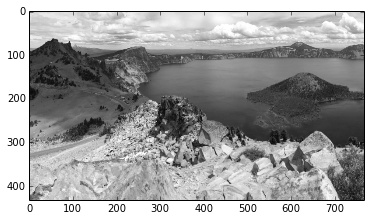

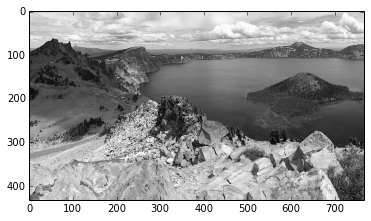

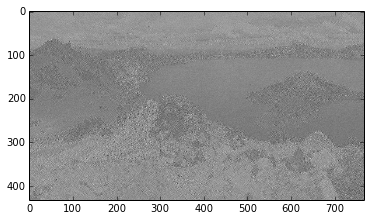

10.034 255.0
10.4188555238 255.0
124.0 1271.0
-390.0 494.0


In [8]:
# Proof of concept of JPEG class
imgIn = imgL[:520,:768]
j = JPEG(imgIn, qtable=JPEG.QL, QF=95)
imgProc = j.process()
jI = JPEG(imgProc, JPEG.QL, QF=95, dims=imgIn.shape, rescale=True)
imgOut = jI.unprocess()


plt.figure()
plt.imshow(imgIn, cmap='gray')
plt.figure()
plt.imshow(imgOut.astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(imgIn - imgOut, cmap='gray')
plt.show()

print np.min(imgIn), np.max(imgOut)
print np.min(imgOut), np.max(imgOut)
print np.min(imgProc[:,0]), np.max(imgProc[:,0])
print np.min(imgProc[:,1:]), np.max(imgProc[:,1:])

In [9]:
def RiFi_preprocess(img):
    # Calculating image shape to be even multiples of 8.
    targetsize = img.shape[0] + (8 - (img.shape[0] % 8)) % 8, \
                 img.shape[1] + (8 - (img.shape[1] % 8)) % 8
    subsize = targetsize[0]//2, targetsize[1]//2                 # subsampling by 2x2
    subsize = subsize[0] + (8 - (subsize[0] % 8)) % 8, \
              subsize[1] + (8 - (subsize[1] % 8)) % 8
    
    # RGB -> YCbCr and subsampling (is it better to 0 pad instead?)
    imgY, imgCb, imgCr = RGB2YCbCr(img)
    imgY = signal.resample(signal.resample(imgY, targetsize[0], axis=0), targetsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, subsize[0], axis=0), subsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, subsize[0], axis=0), subsize[1], axis=1)
    
    # JPEG DCT transformation, quatization, and compression (?)
    bitsY = JPEG(imgY, qtable=JPEG.QL, QF=95).process()
    bitsCb = JPEG(imgCb, qtable=JPEG.QC, QF=95).process()
    bitsCr = JPEG(imgCr, qtable=JPEG.QC, QF=95).process()
    return targetsize, subsize, bitsY, bitsCb, bitsCr
    
def RiFi_postprocess(bitsY, bitsCb, bitsCr, targetsize, subsize, originalsize):
    # Use JPEG class to convert bitarrays back to images
    imgY = JPEG(bitsY, qtable=JPEG.QL, QF=95, dims=targetsize).unprocess()
    imgCb = JPEG(bitsCb, qtable=JPEG.QC, QF=95, dims=subsize).unprocess()
    imgCr = JPEG(bitsCr, qtable=JPEG.QC, QF=95, dims=subsize).unprocess()
    
    # Reconstruct RGB image in original dimensions
    imgY = signal.resample(signal.resample(imgY, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCb = signal.resample(signal.resample(imgCb, originalsize[0], axis=0), originalsize[1], axis=1)
    imgCr = signal.resample(signal.resample(imgCr, originalsize[0], axis=0), originalsize[1], axis=1)
    imgRecon = YCbCr2RGB(imgY, imgCb, imgCr)

    # Rescale image and cast to uint8
    imgRecon[:,:,0] = rescale(imgRecon[:,:,0])
    imgRecon[:,:,1] = rescale(imgRecon[:,:,1])
    imgRecon[:,:,2] = rescale(imgRecon[:,:,2])
    return imgRecon.astype(np.uint8)

In [10]:
tsize, ssize, Y, Cb, Cr = RiFi_preprocess(img)

### TRANSMIT: img.shape[:2], tsize, ssize, Y, Cb, Cr ###

imgRecon = RiFi_postprocess(Y, Cb, Cr, tsize, ssize, (img.shape[0], img.shape[1]))

In [18]:
np.save('y', Y)

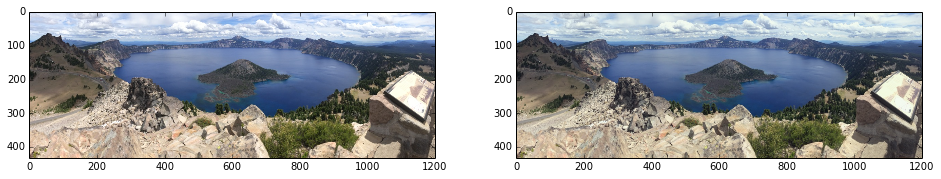

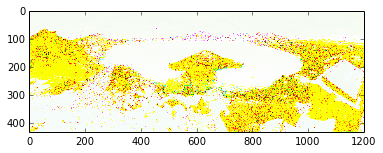

normalized error:  0.0466187228062
(432, 1200, 3)
(432, 1200, 3)


In [16]:
width, height = plt.figaspect(0.25)
fig = plt.figure(figsize=(width,height))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(imgRecon)
misc.imsave('rJpg.tiff', imgRecon)
plt.figure()
plt.imshow(img.astype(np.float64) - imgRecon.astype(np.float64))
plt.show()

print 'normalized error: ', np.linalg.norm(img[:,:,2]-imgRecon[:,:,2]) / np.linalg.norm(img[:,:,2].astype(np.float64))
print img.shape
print imgRecon.shape

In [12]:
misc.imsave(IMG_DIR+'bird_reconstructed.jpg', imgRecon)

In [24]:
import Encoding
import Transmission
reload(Encoding)
reload(Transmission)

print 
eY = Encoding.encode(Y, Encoding.huffmanLookupLuminanceDC, Encoding.huffmanLookupLuminanceAC)
a = len(eY)
# _ = Transmission.testTransmit(e)

eCb = Encoding.encode(Cb, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
b = len(eCb)
# Transmission.testTransmit(e)

eCr = Encoding.encode(Cr, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)
c = len(eCr)
# Transmission.testTransmit(e)

print (a+b+c)//8


223370


In [22]:
len(eY)

1504327